In [1]:
from lstm_model import build_open_loop_lstm, load_open_loop_lstm
from data_processing import create_training_split, df_training_split, create_df_3d, create_window_closed_loop, add_new_pred, compute_lyapunov_time_arr, train_valid_test_split
import tensorflow_datasets as tfds
import time
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['figure.facecolor'] = 'white'
import seaborn as sns

In [3]:
def standardize_data(df_array):
    stand_array = df_array
    for i in range(0, df_array.shape[0]):
        dim = df_array[i, :]
        mean = np.mean(dim)
        std = np.std(dim)
        stand_array[i, :] = (dim-mean)/std
        print(mean, std)
    return stand_array

In [4]:
def df_train_valid_test_split(df, train_ratio=0.6, valid_ratio=0.2):
    len_df_col = len(df)
    train = np.array(df[:, 0:int(len_df_col*train_ratio)])
    valid = np.array(df[:, int(len_df_col*train_ratio): int(len_df_col*(train_ratio + valid_ratio))])
    test = np.array(df[:, int(len_df_col*(train_ratio+valid_ratio)):])
    return train, valid, test

In [5]:
mydf = np.genfromtxt('CSV/lorenz_normalized.csv', delimiter=',')
time = mydf[0, :]
mydf = mydf[1:, :]
df_train, df_test = df_training_split(mydf)
time_train, time_valid, time_test = train_valid_test_split(time)
x_train, x_valid, x_test = train_valid_test_split(mydf[0, :])
y_train, y_valid, y_test = train_valid_test_split(mydf[1, :])
z_train, z_valid, z_test = train_valid_test_split(mydf[2, :])
window_size = 50
batch_size = 32
shuffle_buffer_size = df_train.shape[0]
train_dataset = create_df_3d(df_train.transpose(
), window_size, batch_size, shuffle_buffer_size)
test_dataset = create_df_3d(df_test.transpose(), window_size, batch_size, 1)

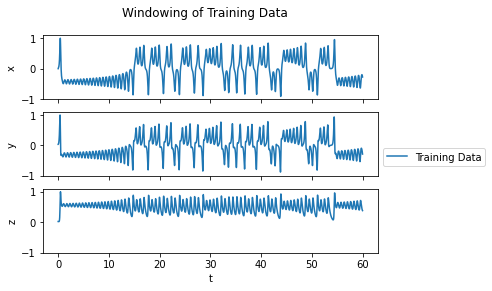

In [6]:
fig, (ax1, ax2, ax3) = plt.subplots(
    3, sharex=True, sharey=True)  # , figsize=(15, 15))
fig.suptitle('Windowing of Training Data')
ax1.plot(time_train, x_train)
ax1.set_ylabel('x')
ax2.plot(time_train, y_train)
ax2.set_ylabel('y')
ax3.plot(time_train, z_train, label='Training Data')
ax3.set_ylabel('z')
ax3.set_xlabel('t')
# ax3.set_xlim(0,1)
ax3.legend(loc='center left', bbox_to_anchor=(1, 1.5))
fig.savefig('Images/train.png', dpi=1000, facecolor="w", bbox_inches='tight')

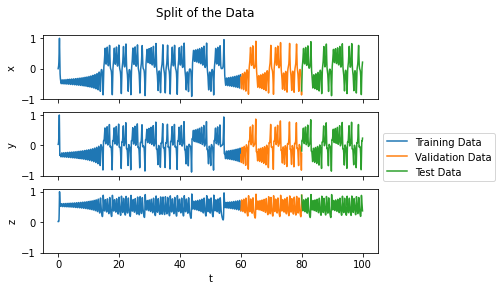

In [7]:
fig, (ax1, ax2, ax3) = plt.subplots(
    3, sharex=True, sharey=True)  # , figsize=(15, 15))
fig.suptitle('Split of the Data')
ax1.plot(time_train, x_train, time_valid, x_valid, time_test, x_test)
ax1.set_ylabel('x')
ax2.plot(time_train, y_train, time_valid, y_valid, time_test, y_test)
ax2.set_ylabel('y')
ax3.plot(time_train, z_train, label='Training Data')
ax3.plot(time_valid, z_valid, label='Validation Data')
ax3.plot(time_test, z_test, label='Test Data')
ax3.set_ylabel('z')
ax3.set_xlabel('t')
# ax3.set_xlim(0,1)
ax3.legend(loc='center left', bbox_to_anchor=(1, 1.5))
fig.savefig('Images/train_valid_test_split.png',
            dpi=1000, facecolor="w", bbox_inches='tight')

In [8]:
model_checkpoint = 'models/oloop_lstm/200_epoch_cp'
model = build_open_loop_lstm()
# Restore the weights
model.load_weights(model_checkpoint)

In [9]:
# np.append(df_train[:, -50:], df_test, axis=1)
test_window = create_window_closed_loop(df_test.transpose(), 0)
predictions = model.predict(test_window)
for iteration in range(1, 1950):
    test_window = create_window_closed_loop(
        df_test.transpose(), iteration, predictions)
    new_pred = model.predict(test_window)
    #new_loss = closed_loop_loss(df_test[:, iteration+1], new_pred)
    # print(new_loss)
    #model.compile(loss=new_loss, optimizer='adam')
    predictions = add_new_pred(predictions, new_pred)
predictions.shape

no network prediction yet


2022-02-07 18:40:12.988358: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


(1950, 3)

In [10]:
lyapunov_time = compute_lyapunov_time_arr(time_test)
lyapunov_path = 'Images/Lyapunov_wide_valid.png'

/Users/eo821/Documents/PhD_research/Lorenz_LSTM/venv/lib/python3.8/site-packages/seaborn/distributions.py:1689: FutureWarning: The `vertical` parameter is deprecated and will be removed in a future version. Assign the data to the `y` variable instead.
  warnings.warn(msg, FutureWarning)
/Users/eo821/Documents/PhD_research/Lorenz_LSTM/venv/lib/python3.8/site-packages/seaborn/distributions.py:1689: FutureWarning: The `vertical` parameter is deprecated and will be removed in a future version. Assign the data to the `y` variable instead.
  warnings.warn(msg, FutureWarning)
/Users/eo821/Documents/PhD_research/Lorenz_LSTM/venv/lib/python3.8/site-packages/seaborn/distributions.py:1689: FutureWarning: The `vertical` parameter is deprecated and will be removed in a future version. Assign the data to the `y` variable instead.
  warnings.warn(msg, FutureWarning)
/Users/eo821/Documents/PhD_research/Lorenz_LSTM/venv/lib/python3.8/site-packages/seaborn/distributions.py:1689: FutureWarning: The `vert

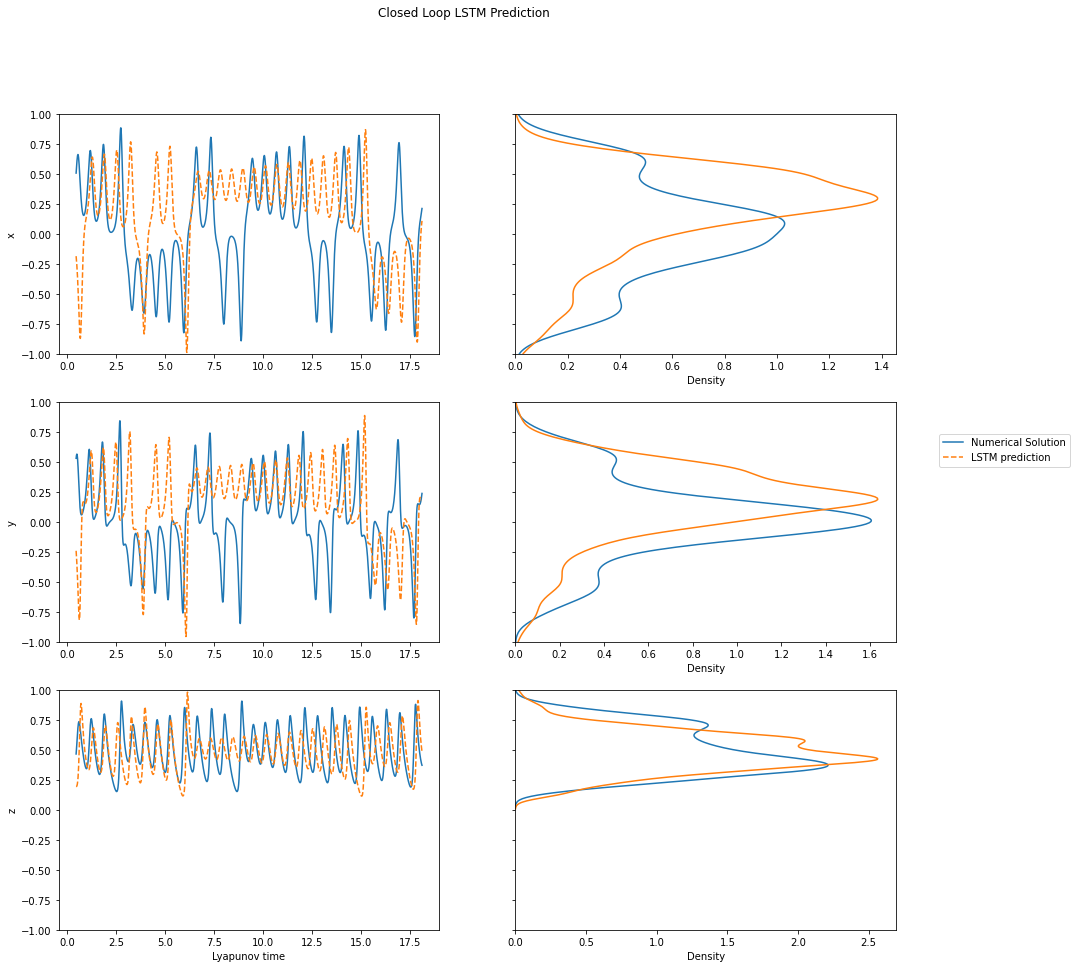

In [33]:
pred_closed_loop = predictions
test_time_end = 50+len(predictions)
fig, axs = plt.subplots(3, 2, sharey=True, facecolor="white", figsize=(15, 15))
fig.suptitle('Closed Loop LSTM Prediction')
axs[0, 0].plot(lyapunov_time[:test_time_end],
               x_test[50:test_time_end], label='True Data')
axs[0, 0].plot(lyapunov_time[:test_time_end],
               pred_closed_loop[:, 0], '--', label='RNN Prediction')
axs[0, 0].set_ylabel('x')
sns.kdeplot(x_test[50:test_time_end], vertical=True,
            color='tab:blue', ax=axs[0, 1])
sns.kdeplot(pred_closed_loop[:, 0], vertical=True,
            color='tab:orange', ax=axs[0, 1])
axs[1, 0].plot(lyapunov_time[:test_time_end],
               y_test[50:test_time_end], label='data')
axs[1, 0].plot(lyapunov_time[:test_time_end], pred_closed_loop[:,
               1], '--', label='RNN prediction on test data')
axs[1, 0].set_ylabel('y')
sns.kdeplot(y_test[50:test_time_end], vertical=True,
            color='tab:blue', ax=axs[1, 1])
sns.kdeplot(pred_closed_loop[:, 1], vertical=True,
            color='tab:orange', ax=axs[1, 1])
axs[2, 0].plot(lyapunov_time[:test_time_end],
               z_test[50:test_time_end], label='Numerical Solution')
axs[2, 0].plot(lyapunov_time[:test_time_end],
               pred_closed_loop[:, 2], '--', label='LSTM prediction')
axs[2, 0].set_ylabel('z')
axs[2, 0].set_xlabel('Lyapunov time')
axs[2, 0].set_ylim(-1, 1)
sns.kdeplot(z_test[50:test_time_end], vertical=True,
            color='tab:blue', ax=axs[2, 1])
sns.kdeplot(pred_closed_loop[:, 2], vertical=True,
            color='tab:orange', ax=axs[2, 1])
# ax3.set_xlim(5,10)
axs[2, 0].legend(loc='center left', bbox_to_anchor=(2.3, 2.0))
plt.show()
#fig.savefig(lyapunov_path, dpi=1000, facecolor="w", bbox_inches='tight')

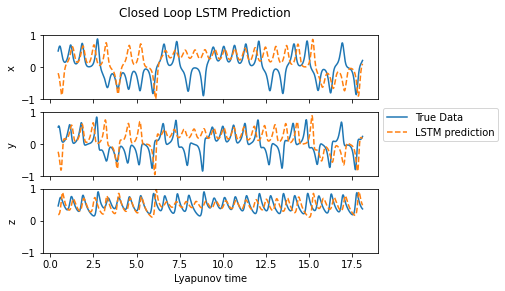

In [14]:
pred_closed_loop = predictions
test_time_end = 50+len(predictions)
fig, (ax1, ax2, ax3) = plt.subplots(3, sharex=True,
                                    sharey=True, facecolor="white")  # , figsize=(15, 15))
fig.suptitle('Closed Loop LSTM Prediction')
ax1.plot(lyapunov_time[:test_time_end],
         x_test[50:test_time_end], label='True Data')
ax1.plot(lyapunov_time[:test_time_end],
         pred_closed_loop[:, 0], '--', label='RNN Prediction')
ax1.set_ylabel('x')

ax2.plot(lyapunov_time[:test_time_end], y_test[50:test_time_end], label='data')
ax2.plot(lyapunov_time[:test_time_end], pred_closed_loop[:,
         1], '--', label='RNN prediction on test data')
ax2.set_ylabel('y')
ax3.plot(lyapunov_time[:test_time_end],
         z_test[50:test_time_end], label='True Data')
ax3.plot(lyapunov_time[:test_time_end],
         pred_closed_loop[:, 2], '--', label='LSTM prediction')
ax3.set_ylabel('z')
ax3.set_xlabel('Lyapunov time')
ax3.set_ylim(-1, 1)
# ax3.set_xlim(5,10)
ax3.legend(loc='center left', bbox_to_anchor=(1, 2.0))
plt.show()
#fig.savefig(lyapunov_path, dpi=1000, facecolor="w", bbox_inches='tight')

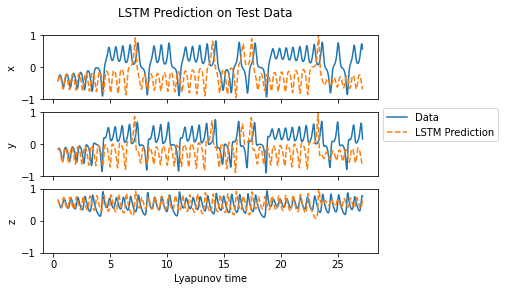

In [13]:
lyapunov_path = 'Images/Lyapunov_wide_valid.png'
pred_closed_loop = predictions
test_time_end = 50 + len(predictions)
fig, (ax1, ax2, ax3) = plt.subplots(3, sharex=True,
                                    sharey=True, facecolor="white")  # , figsize=(15, 15))
fig.suptitle('LSTM Prediction on Test Data')
ax1.plot(lyapunov_time[:test_time_end], x_test[50:test_time_end], label='data')
ax1.plot(lyapunov_time[:test_time_end], pred_closed_loop[:,
         0], '--', label='RNN prediction on test data')
ax1.set_ylabel('x')

ax2.plot(lyapunov_time[:test_time_end], y_test[50:test_time_end], label='data')
ax2.plot(lyapunov_time[:test_time_end], pred_closed_loop[:,
         1], '--', label='RNN prediction on test data')
ax2.set_ylabel('y')
ax3.plot(lyapunov_time[:test_time_end], z_test[50:test_time_end], label='Data')
ax3.plot(lyapunov_time[:test_time_end],
         pred_closed_loop[:, 2], '--', label='LSTM Prediction')
ax3.set_ylabel('z')
ax3.set_xlabel('Lyapunov time')
ax3.set_ylim(-1, 1)
# ax3.set_xlim(0,5)
ax3.legend(loc='center left', bbox_to_anchor=(1, 2.0))
plt.show()

#fig.savefig(lyapunov_path, dpi=1000, facecolor="w", bbox_inches='tight')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


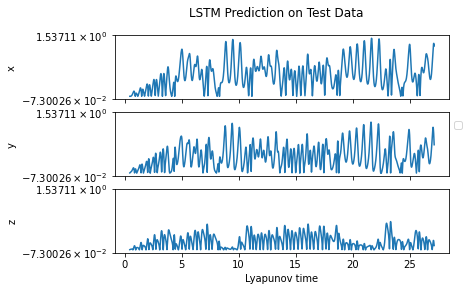

In [18]:
error_lyapunov_time = np.abs(df_test.transpose()[50:, :] - predictions)
test_time_end = 50 + len(predictions)
fig, (ax1, ax2, ax3) = plt.subplots(3, sharex=True,
                                    sharey=True, facecolor="white")  # , figsize=(15, 15))
fig.suptitle('LSTM Prediction on Test Data')
ax1.plot(lyapunov_time[:test_time_end], error_lyapunov_time[:, 0])
ax1.set_ylabel('x')
ax2.plot(lyapunov_time[:test_time_end], error_lyapunov_time[:, 1])
ax2.set_ylabel('y')
ax3.plot(lyapunov_time[:test_time_end], error_lyapunov_time[:, 2])
ax3.set_ylabel('z')
ax3.set_xlabel('Lyapunov time')
ax3.set_yscale('symlog')
# ax3.set_ylim(-0.1,10)
# ax3.set_xlim(0,5)
ax3.legend(loc='center left', bbox_to_anchor=(1, 2.0))
plt.show()

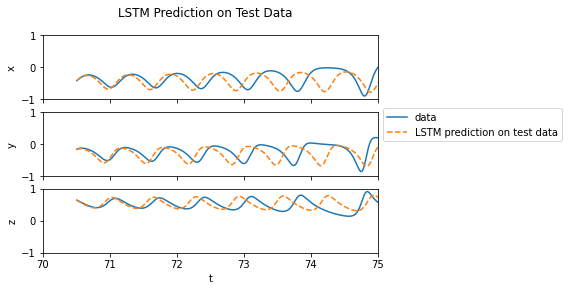

In [19]:
pred_closed_loop = predictions
test_time_end = 50 + len(predictions)
fig, (ax1, ax2, ax3) = plt.subplots(3, sharex=True,
                                    sharey=True, facecolor="white")  # , figsize=(15, 15))
fig.suptitle('LSTM Prediction on Test Data')
ax1.plot(time_test[50:test_time_end], x_test[50:test_time_end], label='data')
ax1.plot(time_test[50:test_time_end], pred_closed_loop[:, 0],
         '--', label='RNN prediction on test data')
ax1.set_ylabel('x')

ax2.plot(time_test[50:test_time_end], y_test[50:test_time_end], label='data')
ax2.plot(time_test[50:test_time_end], pred_closed_loop[:, 1],
         '--', label='RNN prediction on test data')
ax2.set_ylabel('y')
ax3.plot(time_test[50:test_time_end], z_test[50:test_time_end], label='data')
ax3.plot(time_test[50:test_time_end], pred_closed_loop[:, 2],
         '--', label='LSTM prediction on test data')
ax3.set_ylabel('z')
ax3.set_xlabel('t')
ax3.set_ylim(-1, 1)
ax3.legend(loc='center left', bbox_to_anchor=(1, 2.0))
ax3.set_xlim(70, 75)
plt.show()

In [22]:
forecast = model.predict(test_dataset)
testation_filepath = 'Results/prediction_testation'

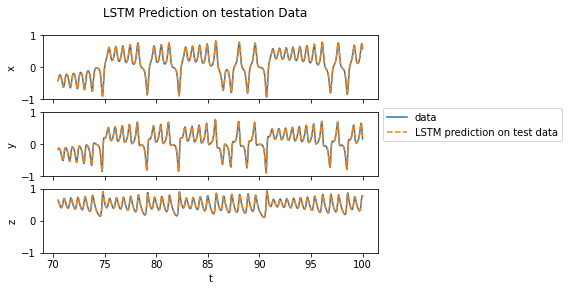

In [29]:
forecast = model.predict(test_dataset)
fig, (ax1, ax2, ax3) = plt.subplots(
    3, sharex=True, sharey=True)  # , figsize=(15, 15))
fig.suptitle('LSTM Prediction on testation Data')
ax1.plot(time_test[50:], x_test[50:], label='data')
ax1.plot(time_test[50:], forecast[:, 0], '--',
         label='RNN prediction on test data')
ax1.set_ylabel('x')
ax2.plot(time_test[50:], y_test[50:], label='data')
ax2.plot(time_test[50:], forecast[:, 1], '--',
         label='RNN prediction on test data')
ax2.set_ylabel('y')
ax3.plot(time_test[50:], z_test[50:], label='data')
ax3.plot(time_test[50:], forecast[:, 2], '--',
         label='LSTM prediction on test data')
ax3.set_ylabel('z')
ax3.set_xlabel('t')
ax3.set_ylim(-1, 1)
ax3.legend(loc='center left', bbox_to_anchor=(1, 2.0))
#fig.savefig(testation_filepath, dpi=1000, facecolor="w", bbox_inches='tight')

In [ ]:
err = df_test.transpose()[50:, :] - forecast
error_filepath = 'Results/absolute_error'

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


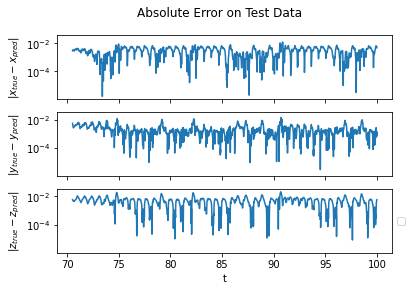

In [28]:
err = df_test.transpose()[50:, :] - forecast
abs_error = np.abs(df_test.transpose()[50:, :] - forecast)

fig, (ax1, ax2, ax3) = plt.subplots(
    3, sharex=True, sharey=True)  # , figsize=(15, 15))
fig.suptitle('Absolute Error on Test Data')
ax1.plot(time_test[50:], abs_error[:, 0])
ax1.set_ylabel(r'$|x_{true}-x_{pred}|$')
ax1.set_yscale('log')
ax2.plot(time_test[50:], abs_error[:, 1])
ax2.set_ylabel(r'$|y_{true}-y_{pred}|$')
ax2.set_yscale('log')
ax3.plot(time_test[50:], abs_error[:, 2])
ax3.set_ylabel(r'$|z_{true}-z_{pred}|$')
ax3.set_xlabel('t')
ax3.set_yscale('log')
ax3.legend(loc='center left', bbox_to_anchor=(1, 0.5))
#fig.savefig(error_filepath, dpi=1000, facecolor="w")